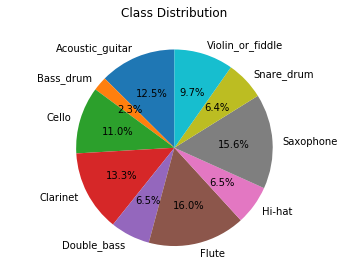

In [141]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from tensorflow.keras.layers import Dropout, Dense, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
from tensorflow.keras import backend
from tensorflow.python.framework import ops
ops.reset_default_graph()
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint
from cfg import Config





def build_rand_feat():
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label == rand_class].index)
        rate, wav = wavfile.read('Clean/'+file)
        label = df.at[file, 'label']
        
        rand_index = np.random.randint(0, wav.shape[0] - config.step) 
        sample = wav[rand_index:rand_index+config.step]
        
        X_sample = mfcc(sample, rate, numcep = config.nfeat, nfilt = config.nfilt, nfft = config.nfft).T
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        
        X.append(X_sample if config.mode == 'conv' else X_sample.T)
        y.append(classes.index(label))
        
    X, y = np.array(X), np.array(y)
    X = (X - _min)/ (_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'time' :
        X = X.shape([0], X.shape[1], X.shape[2])
        
    y = to_categorical(y, num_classes =10)
    return X, y

def get_conv_model():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), activation='relu', strides = (1,1), padding ='same', input_shape = input_shape))
    
    model.add(Conv2D(32, (3,3), activation='relu', strides = (1,1), padding ='same'))
    
    model.add(Conv2D(64, (3,3), activation='relu', strides = (1,1), padding ='same'))
    
    model.add(Conv2D(128, (3,3), activation='relu', strides = (1,1), padding ='same'))
    
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten()) #matrix to vector
    model.add(Dense(128, activation = 'relu')) 
    model.add(Dense(64, activation = 'relu')) 
    model.add(Dense(10, activation = 'softmax')) #last layer
    
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer ='adam', metrics = ['accuracy'])
    return model
   
def get_recurrent_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences = True, input_shape = input_shape))
    model.add(LSTM(128, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation = 'relu')))
    model.add(TimeDistributed(Dense(32, activation = 'relu')))
    model.add(TimeDistributed(Dense(16, activation = 'relu')))
    model.add(TimeDistributed(Dense(8, activation = 'relu')))
    model.add(Flatten())
    model.add(Dense(10, activation = 'softmax')) #last layer
    
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer ='adam', metrics = ['acc'])
    return model
    
    
    
    
    
    
    


df = pd.read_csv('instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

n_samples = 2 * int(df['length'].sum()/ 0.1)
prob_dist = class_dist/class_dist.sum()
choices = np.random.choice(class_dist.index, p = prob_dist)



fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [142]:
config = Config(mode = 'conv')
if config.mode == 'conv' :
    X,y = build_rand_feat()
    y_flat = np.argmax(y, axis = 1)
    input_shape = (X.shape[1], X.shape[2],1)
    model = get_conv_model()
    
elif config.mode == 'time' :
    X,y = build_rand_feat()
    y_flat = np.argmax(y, axis = 1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()

100%|██████████| 26410/26410 [01:22<00:00, 321.58it/s]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 9, 16)         160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 9, 32)         4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 9, 64)         18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 9, 128)        73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 4, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0

In [143]:
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)

model.fit(X, y, epochs = 10, batch_size =32, shuffle = True, class_weight = class_weight )

Train on 26410 samples
Epoch 1/10


 5920/26410 [=====>........................] - ETA: 18:15 - loss: 2.2980 - accuracy: 0.156 - ETA: 9:31 - loss: 2.2863 - accuracy: 0.171 - ETA: 6:37 - loss: 2.2966 - accuracy: 0.16 - ETA: 5:09 - loss: 2.2967 - accuracy: 0.13 - ETA: 4:17 - loss: 2.2978 - accuracy: 0.11 - ETA: 3:42 - loss: 2.2794 - accuracy: 0.13 - ETA: 3:18 - loss: 2.2894 - accuracy: 0.13 - ETA: 2:59 - loss: 2.2907 - accuracy: 0.14 - ETA: 2:45 - loss: 2.2854 - accuracy: 0.14 - ETA: 2:34 - loss: 2.2768 - accuracy: 0.14 - ETA: 2:25 - loss: 2.2760 - accuracy: 0.13 - ETA: 2:17 - loss: 2.2769 - accuracy: 0.14 - ETA: 2:10 - loss: 2.2757 - accuracy: 0.14 - ETA: 2:04 - loss: 2.2726 - accuracy: 0.13 - ETA: 1:59 - loss: 2.2676 - accuracy: 0.14 - ETA: 1:55 - loss: 2.2631 - accuracy: 0.14 - ETA: 1:51 - loss: 2.2621 - accuracy: 0.13 - ETA: 1:48 - loss: 2.2670 - accuracy: 0.13 - ETA: 1:45 - loss: 2.2613 - accuracy: 0.13 - ETA: 1:42 - loss: 2.2544 - accuracy: 0.14 - ETA: 1:39 - loss: 2.2572 - accuracy: 0.14 - ETA: 1:37 - loss: 2.2591 -

17824/26410 [===================>..........] - ETA: 28s - loss: 1.3641 - accuracy: 0.505 - ETA: 28s - loss: 1.3626 - accuracy: 0.506 - ETA: 28s - loss: 1.3614 - accuracy: 0.507 - ETA: 28s - loss: 1.3598 - accuracy: 0.507 - ETA: 28s - loss: 1.3593 - accuracy: 0.508 - ETA: 28s - loss: 1.3586 - accuracy: 0.508 - ETA: 28s - loss: 1.3572 - accuracy: 0.508 - ETA: 28s - loss: 1.3555 - accuracy: 0.509 - ETA: 28s - loss: 1.3537 - accuracy: 0.510 - ETA: 28s - loss: 1.3526 - accuracy: 0.510 - ETA: 28s - loss: 1.3510 - accuracy: 0.511 - ETA: 27s - loss: 1.3510 - accuracy: 0.511 - ETA: 27s - loss: 1.3504 - accuracy: 0.511 - ETA: 27s - loss: 1.3502 - accuracy: 0.511 - ETA: 27s - loss: 1.3499 - accuracy: 0.512 - ETA: 27s - loss: 1.3486 - accuracy: 0.512 - ETA: 27s - loss: 1.3474 - accuracy: 0.513 - ETA: 27s - loss: 1.3465 - accuracy: 0.513 - ETA: 27s - loss: 1.3455 - accuracy: 0.513 - ETA: 27s - loss: 1.3448 - accuracy: 0.513 - ETA: 27s - loss: 1.3448 - accuracy: 0.514 - ETA: 27s - loss: 1.3436 - acc

23872/26410 [==========================>...] - ETA: 16s - loss: 1.1930 - accuracy: 0.570 - ETA: 16s - loss: 1.1925 - accuracy: 0.571 - ETA: 16s - loss: 1.1914 - accuracy: 0.571 - ETA: 16s - loss: 1.1902 - accuracy: 0.572 - ETA: 16s - loss: 1.1896 - accuracy: 0.572 - ETA: 16s - loss: 1.1890 - accuracy: 0.572 - ETA: 16s - loss: 1.1884 - accuracy: 0.572 - ETA: 16s - loss: 1.1878 - accuracy: 0.572 - ETA: 16s - loss: 1.1870 - accuracy: 0.573 - ETA: 15s - loss: 1.1864 - accuracy: 0.573 - ETA: 15s - loss: 1.1856 - accuracy: 0.573 - ETA: 15s - loss: 1.1847 - accuracy: 0.574 - ETA: 15s - loss: 1.1835 - accuracy: 0.574 - ETA: 15s - loss: 1.1824 - accuracy: 0.574 - ETA: 15s - loss: 1.1814 - accuracy: 0.575 - ETA: 15s - loss: 1.1806 - accuracy: 0.575 - ETA: 15s - loss: 1.1800 - accuracy: 0.575 - ETA: 15s - loss: 1.1788 - accuracy: 0.576 - ETA: 15s - loss: 1.1779 - accuracy: 0.576 - ETA: 15s - loss: 1.1770 - accuracy: 0.576 - ETA: 15s - loss: 1.1762 - accuracy: 0.577 - ETA: 15s - loss: 1.1752 - acc

26410/26410 [==============================] - ETA: 4s - loss: 1.0651 - accuracy: 0.62 - ETA: 4s - loss: 1.0651 - accuracy: 0.62 - ETA: 4s - loss: 1.0641 - accuracy: 0.62 - ETA: 4s - loss: 1.0639 - accuracy: 0.62 - ETA: 4s - loss: 1.0635 - accuracy: 0.62 - ETA: 4s - loss: 1.0626 - accuracy: 0.62 - ETA: 4s - loss: 1.0618 - accuracy: 0.62 - ETA: 4s - loss: 1.0608 - accuracy: 0.62 - ETA: 4s - loss: 1.0607 - accuracy: 0.62 - ETA: 4s - loss: 1.0603 - accuracy: 0.62 - ETA: 4s - loss: 1.0599 - accuracy: 0.62 - ETA: 4s - loss: 1.0594 - accuracy: 0.62 - ETA: 4s - loss: 1.0589 - accuracy: 0.62 - ETA: 3s - loss: 1.0581 - accuracy: 0.62 - ETA: 3s - loss: 1.0574 - accuracy: 0.62 - ETA: 3s - loss: 1.0569 - accuracy: 0.62 - ETA: 3s - loss: 1.0564 - accuracy: 0.62 - ETA: 3s - loss: 1.0557 - accuracy: 0.62 - ETA: 3s - loss: 1.0552 - accuracy: 0.62 - ETA: 3s - loss: 1.0545 - accuracy: 0.62 - ETA: 3s - loss: 1.0539 - accuracy: 0.62 - ETA: 3s - loss: 1.0531 - accuracy: 0.62 - ETA: 3s - loss: 1.0528 - accu

 5952/26410 [=====>........................] - ETA: 51s - loss: 0.5940 - accuracy: 0.781 - ETA: 51s - loss: 0.5404 - accuracy: 0.812 - ETA: 51s - loss: 0.6384 - accuracy: 0.791 - ETA: 52s - loss: 0.6723 - accuracy: 0.773 - ETA: 52s - loss: 0.6684 - accuracy: 0.781 - ETA: 52s - loss: 0.6558 - accuracy: 0.786 - ETA: 52s - loss: 0.6600 - accuracy: 0.776 - ETA: 51s - loss: 0.6329 - accuracy: 0.789 - ETA: 51s - loss: 0.6175 - accuracy: 0.795 - ETA: 51s - loss: 0.5940 - accuracy: 0.809 - ETA: 51s - loss: 0.5772 - accuracy: 0.815 - ETA: 51s - loss: 0.5926 - accuracy: 0.804 - ETA: 50s - loss: 0.5853 - accuracy: 0.810 - ETA: 50s - loss: 0.5848 - accuracy: 0.805 - ETA: 50s - loss: 0.5737 - accuracy: 0.806 - ETA: 49s - loss: 0.5653 - accuracy: 0.806 - ETA: 49s - loss: 0.5548 - accuracy: 0.808 - ETA: 49s - loss: 0.5671 - accuracy: 0.805 - ETA: 49s - loss: 0.5840 - accuracy: 0.796 - ETA: 48s - loss: 0.6040 - accuracy: 0.787 - ETA: 48s - loss: 0.5890 - accuracy: 0.796 - ETA: 48s - loss: 0.5877 - acc

18464/26410 [===================>..........] - ETA: 25s - loss: 0.5142 - accuracy: 0.825 - ETA: 25s - loss: 0.5140 - accuracy: 0.825 - ETA: 25s - loss: 0.5141 - accuracy: 0.825 - ETA: 25s - loss: 0.5136 - accuracy: 0.825 - ETA: 25s - loss: 0.5133 - accuracy: 0.825 - ETA: 25s - loss: 0.5135 - accuracy: 0.825 - ETA: 25s - loss: 0.5146 - accuracy: 0.825 - ETA: 25s - loss: 0.5147 - accuracy: 0.824 - ETA: 25s - loss: 0.5152 - accuracy: 0.824 - ETA: 25s - loss: 0.5150 - accuracy: 0.824 - ETA: 25s - loss: 0.5148 - accuracy: 0.824 - ETA: 24s - loss: 0.5144 - accuracy: 0.825 - ETA: 24s - loss: 0.5141 - accuracy: 0.825 - ETA: 24s - loss: 0.5137 - accuracy: 0.825 - ETA: 24s - loss: 0.5140 - accuracy: 0.825 - ETA: 24s - loss: 0.5145 - accuracy: 0.825 - ETA: 24s - loss: 0.5138 - accuracy: 0.825 - ETA: 24s - loss: 0.5135 - accuracy: 0.825 - ETA: 24s - loss: 0.5133 - accuracy: 0.825 - ETA: 24s - loss: 0.5135 - accuracy: 0.825 - ETA: 24s - loss: 0.5132 - accuracy: 0.825 - ETA: 24s - loss: 0.5131 - acc

24896/26410 [===========================>..] - ETA: 14s - loss: 0.4999 - accuracy: 0.829 - ETA: 14s - loss: 0.5003 - accuracy: 0.829 - ETA: 14s - loss: 0.4999 - accuracy: 0.829 - ETA: 14s - loss: 0.4997 - accuracy: 0.829 - ETA: 14s - loss: 0.4994 - accuracy: 0.829 - ETA: 14s - loss: 0.4990 - accuracy: 0.829 - ETA: 13s - loss: 0.4982 - accuracy: 0.830 - ETA: 13s - loss: 0.4983 - accuracy: 0.830 - ETA: 13s - loss: 0.4980 - accuracy: 0.830 - ETA: 13s - loss: 0.4979 - accuracy: 0.830 - ETA: 13s - loss: 0.4979 - accuracy: 0.830 - ETA: 13s - loss: 0.4978 - accuracy: 0.830 - ETA: 13s - loss: 0.4974 - accuracy: 0.830 - ETA: 13s - loss: 0.4973 - accuracy: 0.830 - ETA: 13s - loss: 0.4969 - accuracy: 0.830 - ETA: 13s - loss: 0.4969 - accuracy: 0.830 - ETA: 13s - loss: 0.4966 - accuracy: 0.830 - ETA: 13s - loss: 0.4964 - accuracy: 0.830 - ETA: 13s - loss: 0.4962 - accuracy: 0.830 - ETA: 13s - loss: 0.4962 - accuracy: 0.830 - ETA: 13s - loss: 0.4962 - accuracy: 0.830 - ETA: 12s - loss: 0.4961 - acc

26410/26410 [==============================] - ETA: 2s - loss: 0.4878 - accuracy: 0.83 - ETA: 2s - loss: 0.4879 - accuracy: 0.83 - ETA: 2s - loss: 0.4878 - accuracy: 0.83 - ETA: 2s - loss: 0.4876 - accuracy: 0.83 - ETA: 2s - loss: 0.4873 - accuracy: 0.83 - ETA: 2s - loss: 0.4871 - accuracy: 0.83 - ETA: 2s - loss: 0.4869 - accuracy: 0.83 - ETA: 2s - loss: 0.4868 - accuracy: 0.83 - ETA: 2s - loss: 0.4868 - accuracy: 0.83 - ETA: 2s - loss: 0.4864 - accuracy: 0.83 - ETA: 2s - loss: 0.4868 - accuracy: 0.83 - ETA: 2s - loss: 0.4868 - accuracy: 0.83 - ETA: 1s - loss: 0.4866 - accuracy: 0.83 - ETA: 1s - loss: 0.4864 - accuracy: 0.83 - ETA: 1s - loss: 0.4864 - accuracy: 0.83 - ETA: 1s - loss: 0.4861 - accuracy: 0.83 - ETA: 1s - loss: 0.4858 - accuracy: 0.83 - ETA: 1s - loss: 0.4858 - accuracy: 0.83 - ETA: 1s - loss: 0.4856 - accuracy: 0.83 - ETA: 1s - loss: 0.4853 - accuracy: 0.83 - ETA: 1s - loss: 0.4851 - accuracy: 0.83 - ETA: 1s - loss: 0.4850 - accuracy: 0.83 - ETA: 1s - loss: 0.4851 - accu

 6208/26410 [======>.......................] - ETA: 47s - loss: 0.3219 - accuracy: 0.875 - ETA: 50s - loss: 0.2793 - accuracy: 0.890 - ETA: 50s - loss: 0.2853 - accuracy: 0.875 - ETA: 49s - loss: 0.3063 - accuracy: 0.875 - ETA: 50s - loss: 0.3287 - accuracy: 0.868 - ETA: 50s - loss: 0.3776 - accuracy: 0.854 - ETA: 49s - loss: 0.4103 - accuracy: 0.848 - ETA: 50s - loss: 0.4330 - accuracy: 0.851 - ETA: 50s - loss: 0.4494 - accuracy: 0.847 - ETA: 49s - loss: 0.4461 - accuracy: 0.850 - ETA: 50s - loss: 0.4418 - accuracy: 0.849 - ETA: 50s - loss: 0.4514 - accuracy: 0.851 - ETA: 50s - loss: 0.4577 - accuracy: 0.853 - ETA: 50s - loss: 0.4346 - accuracy: 0.859 - ETA: 50s - loss: 0.4359 - accuracy: 0.860 - ETA: 50s - loss: 0.4256 - accuracy: 0.865 - ETA: 50s - loss: 0.4286 - accuracy: 0.867 - ETA: 50s - loss: 0.4137 - accuracy: 0.873 - ETA: 50s - loss: 0.4262 - accuracy: 0.871 - ETA: 49s - loss: 0.4282 - accuracy: 0.871 - ETA: 49s - loss: 0.4264 - accuracy: 0.873 - ETA: 49s - loss: 0.4228 - acc

18688/26410 [====================>.........] - ETA: 25s - loss: 0.3506 - accuracy: 0.880 - ETA: 25s - loss: 0.3506 - accuracy: 0.880 - ETA: 25s - loss: 0.3505 - accuracy: 0.880 - ETA: 25s - loss: 0.3501 - accuracy: 0.880 - ETA: 25s - loss: 0.3502 - accuracy: 0.880 - ETA: 25s - loss: 0.3500 - accuracy: 0.880 - ETA: 25s - loss: 0.3496 - accuracy: 0.880 - ETA: 25s - loss: 0.3491 - accuracy: 0.881 - ETA: 24s - loss: 0.3493 - accuracy: 0.880 - ETA: 24s - loss: 0.3490 - accuracy: 0.881 - ETA: 24s - loss: 0.3484 - accuracy: 0.881 - ETA: 24s - loss: 0.3485 - accuracy: 0.881 - ETA: 24s - loss: 0.3484 - accuracy: 0.881 - ETA: 24s - loss: 0.3486 - accuracy: 0.881 - ETA: 24s - loss: 0.3486 - accuracy: 0.881 - ETA: 24s - loss: 0.3488 - accuracy: 0.881 - ETA: 24s - loss: 0.3485 - accuracy: 0.881 - ETA: 24s - loss: 0.3485 - accuracy: 0.881 - ETA: 24s - loss: 0.3485 - accuracy: 0.881 - ETA: 24s - loss: 0.3481 - accuracy: 0.881 - ETA: 24s - loss: 0.3482 - accuracy: 0.881 - ETA: 24s - loss: 0.3480 - acc

25408/26410 [===========================>..] - ETA: 13s - loss: 0.3437 - accuracy: 0.882 - ETA: 13s - loss: 0.3436 - accuracy: 0.882 - ETA: 13s - loss: 0.3436 - accuracy: 0.882 - ETA: 13s - loss: 0.3433 - accuracy: 0.882 - ETA: 13s - loss: 0.3429 - accuracy: 0.882 - ETA: 13s - loss: 0.3426 - accuracy: 0.882 - ETA: 13s - loss: 0.3424 - accuracy: 0.882 - ETA: 13s - loss: 0.3423 - accuracy: 0.882 - ETA: 13s - loss: 0.3425 - accuracy: 0.882 - ETA: 13s - loss: 0.3425 - accuracy: 0.882 - ETA: 13s - loss: 0.3423 - accuracy: 0.882 - ETA: 13s - loss: 0.3424 - accuracy: 0.882 - ETA: 13s - loss: 0.3418 - accuracy: 0.882 - ETA: 13s - loss: 0.3418 - accuracy: 0.882 - ETA: 12s - loss: 0.3412 - accuracy: 0.882 - ETA: 12s - loss: 0.3411 - accuracy: 0.882 - ETA: 12s - loss: 0.3410 - accuracy: 0.882 - ETA: 12s - loss: 0.3408 - accuracy: 0.882 - ETA: 12s - loss: 0.3411 - accuracy: 0.882 - ETA: 12s - loss: 0.3409 - accuracy: 0.882 - ETA: 12s - loss: 0.3409 - accuracy: 0.882 - ETA: 12s - loss: 0.3407 - acc

26410/26410 [==============================] - ETA: 1s - loss: 0.3346 - accuracy: 0.88 - ETA: 1s - loss: 0.3342 - accuracy: 0.88 - ETA: 1s - loss: 0.3344 - accuracy: 0.88 - ETA: 1s - loss: 0.3348 - accuracy: 0.88 - ETA: 1s - loss: 0.3348 - accuracy: 0.88 - ETA: 1s - loss: 0.3348 - accuracy: 0.88 - ETA: 1s - loss: 0.3348 - accuracy: 0.88 - ETA: 1s - loss: 0.3347 - accuracy: 0.88 - ETA: 1s - loss: 0.3345 - accuracy: 0.88 - ETA: 1s - loss: 0.3344 - accuracy: 0.88 - ETA: 1s - loss: 0.3345 - accuracy: 0.88 - ETA: 1s - loss: 0.3344 - accuracy: 0.88 - ETA: 0s - loss: 0.3344 - accuracy: 0.88 - ETA: 0s - loss: 0.3345 - accuracy: 0.88 - ETA: 0s - loss: 0.3349 - accuracy: 0.88 - ETA: 0s - loss: 0.3347 - accuracy: 0.88 - ETA: 0s - loss: 0.3348 - accuracy: 0.88 - ETA: 0s - loss: 0.3348 - accuracy: 0.88 - ETA: 0s - loss: 0.3347 - accuracy: 0.88 - ETA: 0s - loss: 0.3349 - accuracy: 0.88 - ETA: 0s - loss: 0.3348 - accuracy: 0.88 - ETA: 0s - loss: 0.3347 - accuracy: 0.88 - ETA: 0s - loss: 0.3346 - accu

 6176/26410 [======>.......................] - ETA: 45s - loss: 0.2736 - accuracy: 0.906 - ETA: 45s - loss: 0.5482 - accuracy: 0.828 - ETA: 45s - loss: 0.4924 - accuracy: 0.843 - ETA: 46s - loss: 0.4145 - accuracy: 0.867 - ETA: 46s - loss: 0.4015 - accuracy: 0.875 - ETA: 47s - loss: 0.4155 - accuracy: 0.869 - ETA: 47s - loss: 0.3860 - accuracy: 0.875 - ETA: 47s - loss: 0.3466 - accuracy: 0.890 - ETA: 48s - loss: 0.3436 - accuracy: 0.888 - ETA: 48s - loss: 0.3389 - accuracy: 0.890 - ETA: 49s - loss: 0.3558 - accuracy: 0.889 - ETA: 49s - loss: 0.3464 - accuracy: 0.895 - ETA: 49s - loss: 0.3242 - accuracy: 0.903 - ETA: 49s - loss: 0.3118 - accuracy: 0.908 - ETA: 49s - loss: 0.3087 - accuracy: 0.908 - ETA: 49s - loss: 0.3019 - accuracy: 0.910 - ETA: 50s - loss: 0.2980 - accuracy: 0.911 - ETA: 50s - loss: 0.3026 - accuracy: 0.911 - ETA: 50s - loss: 0.3024 - accuracy: 0.909 - ETA: 50s - loss: 0.2921 - accuracy: 0.914 - ETA: 50s - loss: 0.2874 - accuracy: 0.912 - ETA: 50s - loss: 0.2853 - acc

18688/26410 [====================>.........] - ETA: 25s - loss: 0.2815 - accuracy: 0.902 - ETA: 25s - loss: 0.2816 - accuracy: 0.902 - ETA: 25s - loss: 0.2816 - accuracy: 0.902 - ETA: 25s - loss: 0.2815 - accuracy: 0.902 - ETA: 25s - loss: 0.2817 - accuracy: 0.902 - ETA: 25s - loss: 0.2813 - accuracy: 0.902 - ETA: 24s - loss: 0.2815 - accuracy: 0.902 - ETA: 24s - loss: 0.2810 - accuracy: 0.902 - ETA: 24s - loss: 0.2808 - accuracy: 0.902 - ETA: 24s - loss: 0.2809 - accuracy: 0.902 - ETA: 24s - loss: 0.2804 - accuracy: 0.902 - ETA: 24s - loss: 0.2808 - accuracy: 0.902 - ETA: 24s - loss: 0.2807 - accuracy: 0.902 - ETA: 24s - loss: 0.2802 - accuracy: 0.902 - ETA: 24s - loss: 0.2799 - accuracy: 0.902 - ETA: 24s - loss: 0.2794 - accuracy: 0.903 - ETA: 24s - loss: 0.2790 - accuracy: 0.903 - ETA: 24s - loss: 0.2789 - accuracy: 0.903 - ETA: 24s - loss: 0.2785 - accuracy: 0.903 - ETA: 24s - loss: 0.2783 - accuracy: 0.903 - ETA: 24s - loss: 0.2784 - accuracy: 0.903 - ETA: 24s - loss: 0.2783 - acc

25216/26410 [===========================>..] - ETA: 13s - loss: 0.2646 - accuracy: 0.907 - ETA: 13s - loss: 0.2650 - accuracy: 0.906 - ETA: 13s - loss: 0.2648 - accuracy: 0.906 - ETA: 13s - loss: 0.2650 - accuracy: 0.906 - ETA: 13s - loss: 0.2652 - accuracy: 0.906 - ETA: 13s - loss: 0.2653 - accuracy: 0.906 - ETA: 13s - loss: 0.2652 - accuracy: 0.906 - ETA: 13s - loss: 0.2650 - accuracy: 0.906 - ETA: 13s - loss: 0.2652 - accuracy: 0.906 - ETA: 13s - loss: 0.2650 - accuracy: 0.906 - ETA: 13s - loss: 0.2646 - accuracy: 0.906 - ETA: 13s - loss: 0.2643 - accuracy: 0.907 - ETA: 13s - loss: 0.2641 - accuracy: 0.907 - ETA: 13s - loss: 0.2645 - accuracy: 0.907 - ETA: 12s - loss: 0.2648 - accuracy: 0.907 - ETA: 12s - loss: 0.2645 - accuracy: 0.907 - ETA: 12s - loss: 0.2643 - accuracy: 0.907 - ETA: 12s - loss: 0.2641 - accuracy: 0.907 - ETA: 12s - loss: 0.2638 - accuracy: 0.907 - ETA: 12s - loss: 0.2636 - accuracy: 0.907 - ETA: 12s - loss: 0.2634 - accuracy: 0.907 - ETA: 12s - loss: 0.2638 - acc

26410/26410 [==============================] - ETA: 2s - loss: 0.2614 - accuracy: 0.90 - ETA: 2s - loss: 0.2613 - accuracy: 0.90 - ETA: 1s - loss: 0.2615 - accuracy: 0.90 - ETA: 1s - loss: 0.2614 - accuracy: 0.90 - ETA: 1s - loss: 0.2614 - accuracy: 0.90 - ETA: 1s - loss: 0.2612 - accuracy: 0.90 - ETA: 1s - loss: 0.2612 - accuracy: 0.90 - ETA: 1s - loss: 0.2610 - accuracy: 0.90 - ETA: 1s - loss: 0.2614 - accuracy: 0.90 - ETA: 1s - loss: 0.2613 - accuracy: 0.90 - ETA: 1s - loss: 0.2611 - accuracy: 0.90 - ETA: 1s - loss: 0.2608 - accuracy: 0.90 - ETA: 1s - loss: 0.2610 - accuracy: 0.90 - ETA: 1s - loss: 0.2609 - accuracy: 0.90 - ETA: 1s - loss: 0.2609 - accuracy: 0.90 - ETA: 1s - loss: 0.2607 - accuracy: 0.90 - ETA: 1s - loss: 0.2607 - accuracy: 0.90 - ETA: 1s - loss: 0.2606 - accuracy: 0.90 - ETA: 0s - loss: 0.2604 - accuracy: 0.90 - ETA: 0s - loss: 0.2602 - accuracy: 0.90 - ETA: 0s - loss: 0.2603 - accuracy: 0.90 - ETA: 0s - loss: 0.2601 - accuracy: 0.90 - ETA: 0s - loss: 0.2605 - accu

 6304/26410 [======>.......................] - ETA: 42s - loss: 0.3903 - accuracy: 0.843 - ETA: 44s - loss: 0.2406 - accuracy: 0.921 - ETA: 45s - loss: 0.2282 - accuracy: 0.916 - ETA: 45s - loss: 0.1890 - accuracy: 0.937 - ETA: 45s - loss: 0.1997 - accuracy: 0.937 - ETA: 46s - loss: 0.2205 - accuracy: 0.927 - ETA: 44s - loss: 0.1913 - accuracy: 0.941 - ETA: 45s - loss: 0.1969 - accuracy: 0.937 - ETA: 45s - loss: 0.1932 - accuracy: 0.934 - ETA: 45s - loss: 0.1922 - accuracy: 0.931 - ETA: 46s - loss: 0.1966 - accuracy: 0.927 - ETA: 46s - loss: 0.1981 - accuracy: 0.920 - ETA: 46s - loss: 0.1923 - accuracy: 0.921 - ETA: 47s - loss: 0.1933 - accuracy: 0.922 - ETA: 46s - loss: 0.1838 - accuracy: 0.926 - ETA: 47s - loss: 0.1828 - accuracy: 0.925 - ETA: 47s - loss: 0.1774 - accuracy: 0.927 - ETA: 47s - loss: 0.1770 - accuracy: 0.926 - ETA: 47s - loss: 0.1793 - accuracy: 0.924 - ETA: 47s - loss: 0.1766 - accuracy: 0.926 - ETA: 47s - loss: 0.1730 - accuracy: 0.926 - ETA: 48s - loss: 0.1756 - acc

18560/26410 [====================>.........] - ETA: 25s - loss: 0.2150 - accuracy: 0.923 - ETA: 25s - loss: 0.2148 - accuracy: 0.923 - ETA: 25s - loss: 0.2147 - accuracy: 0.923 - ETA: 25s - loss: 0.2145 - accuracy: 0.923 - ETA: 25s - loss: 0.2143 - accuracy: 0.923 - ETA: 25s - loss: 0.2142 - accuracy: 0.923 - ETA: 24s - loss: 0.2146 - accuracy: 0.924 - ETA: 24s - loss: 0.2146 - accuracy: 0.923 - ETA: 24s - loss: 0.2153 - accuracy: 0.923 - ETA: 24s - loss: 0.2151 - accuracy: 0.923 - ETA: 24s - loss: 0.2147 - accuracy: 0.923 - ETA: 24s - loss: 0.2148 - accuracy: 0.923 - ETA: 24s - loss: 0.2151 - accuracy: 0.923 - ETA: 24s - loss: 0.2156 - accuracy: 0.923 - ETA: 24s - loss: 0.2155 - accuracy: 0.923 - ETA: 24s - loss: 0.2153 - accuracy: 0.923 - ETA: 24s - loss: 0.2153 - accuracy: 0.923 - ETA: 24s - loss: 0.2153 - accuracy: 0.923 - ETA: 24s - loss: 0.2151 - accuracy: 0.923 - ETA: 24s - loss: 0.2151 - accuracy: 0.923 - ETA: 24s - loss: 0.2149 - accuracy: 0.923 - ETA: 24s - loss: 0.2152 - acc

24960/26410 [===========================>..] - ETA: 14s - loss: 0.2149 - accuracy: 0.924 - ETA: 14s - loss: 0.2150 - accuracy: 0.924 - ETA: 14s - loss: 0.2148 - accuracy: 0.924 - ETA: 13s - loss: 0.2147 - accuracy: 0.924 - ETA: 13s - loss: 0.2148 - accuracy: 0.924 - ETA: 13s - loss: 0.2146 - accuracy: 0.924 - ETA: 13s - loss: 0.2147 - accuracy: 0.924 - ETA: 13s - loss: 0.2147 - accuracy: 0.924 - ETA: 13s - loss: 0.2145 - accuracy: 0.924 - ETA: 13s - loss: 0.2144 - accuracy: 0.924 - ETA: 13s - loss: 0.2145 - accuracy: 0.924 - ETA: 13s - loss: 0.2146 - accuracy: 0.924 - ETA: 13s - loss: 0.2143 - accuracy: 0.924 - ETA: 13s - loss: 0.2140 - accuracy: 0.924 - ETA: 13s - loss: 0.2140 - accuracy: 0.924 - ETA: 13s - loss: 0.2141 - accuracy: 0.924 - ETA: 13s - loss: 0.2140 - accuracy: 0.924 - ETA: 13s - loss: 0.2141 - accuracy: 0.924 - ETA: 13s - loss: 0.2140 - accuracy: 0.924 - ETA: 13s - loss: 0.2139 - accuracy: 0.924 - ETA: 13s - loss: 0.2137 - accuracy: 0.924 - ETA: 12s - loss: 0.2141 - acc

26410/26410 [==============================] - ETA: 2s - loss: 0.2125 - accuracy: 0.92 - ETA: 2s - loss: 0.2128 - accuracy: 0.92 - ETA: 2s - loss: 0.2129 - accuracy: 0.92 - ETA: 2s - loss: 0.2134 - accuracy: 0.92 - ETA: 2s - loss: 0.2140 - accuracy: 0.92 - ETA: 2s - loss: 0.2140 - accuracy: 0.92 - ETA: 2s - loss: 0.2140 - accuracy: 0.92 - ETA: 2s - loss: 0.2140 - accuracy: 0.92 - ETA: 2s - loss: 0.2140 - accuracy: 0.92 - ETA: 1s - loss: 0.2145 - accuracy: 0.92 - ETA: 1s - loss: 0.2146 - accuracy: 0.92 - ETA: 1s - loss: 0.2147 - accuracy: 0.92 - ETA: 1s - loss: 0.2146 - accuracy: 0.92 - ETA: 1s - loss: 0.2148 - accuracy: 0.92 - ETA: 1s - loss: 0.2148 - accuracy: 0.92 - ETA: 1s - loss: 0.2151 - accuracy: 0.92 - ETA: 1s - loss: 0.2154 - accuracy: 0.92 - ETA: 1s - loss: 0.2153 - accuracy: 0.92 - ETA: 1s - loss: 0.2152 - accuracy: 0.92 - ETA: 1s - loss: 0.2152 - accuracy: 0.92 - ETA: 1s - loss: 0.2151 - accuracy: 0.92 - ETA: 1s - loss: 0.2150 - accuracy: 0.92 - ETA: 1s - loss: 0.2149 - accu

 6272/26410 [======>.......................] - ETA: 45s - loss: 0.1689 - accuracy: 0.906 - ETA: 45s - loss: 0.2709 - accuracy: 0.890 - ETA: 46s - loss: 0.2080 - accuracy: 0.916 - ETA: 46s - loss: 0.1857 - accuracy: 0.921 - ETA: 45s - loss: 0.1933 - accuracy: 0.912 - ETA: 46s - loss: 0.1886 - accuracy: 0.911 - ETA: 46s - loss: 0.1792 - accuracy: 0.919 - ETA: 46s - loss: 0.1836 - accuracy: 0.918 - ETA: 46s - loss: 0.1695 - accuracy: 0.927 - ETA: 44s - loss: 0.1712 - accuracy: 0.926 - ETA: 45s - loss: 0.1808 - accuracy: 0.921 - ETA: 45s - loss: 0.1805 - accuracy: 0.925 - ETA: 45s - loss: 0.1800 - accuracy: 0.928 - ETA: 45s - loss: 0.1835 - accuracy: 0.927 - ETA: 45s - loss: 0.2039 - accuracy: 0.927 - ETA: 45s - loss: 0.2123 - accuracy: 0.926 - ETA: 46s - loss: 0.2124 - accuracy: 0.927 - ETA: 46s - loss: 0.2030 - accuracy: 0.930 - ETA: 46s - loss: 0.2103 - accuracy: 0.928 - ETA: 46s - loss: 0.2277 - accuracy: 0.924 - ETA: 46s - loss: 0.2241 - accuracy: 0.926 - ETA: 46s - loss: 0.2180 - acc

18976/26410 [====================>.........] - ETA: 25s - loss: 0.1877 - accuracy: 0.933 - ETA: 24s - loss: 0.1875 - accuracy: 0.934 - ETA: 24s - loss: 0.1872 - accuracy: 0.934 - ETA: 24s - loss: 0.1869 - accuracy: 0.934 - ETA: 24s - loss: 0.1865 - accuracy: 0.934 - ETA: 24s - loss: 0.1863 - accuracy: 0.934 - ETA: 24s - loss: 0.1866 - accuracy: 0.934 - ETA: 24s - loss: 0.1880 - accuracy: 0.934 - ETA: 24s - loss: 0.1879 - accuracy: 0.933 - ETA: 24s - loss: 0.1882 - accuracy: 0.933 - ETA: 24s - loss: 0.1881 - accuracy: 0.934 - ETA: 24s - loss: 0.1879 - accuracy: 0.934 - ETA: 24s - loss: 0.1876 - accuracy: 0.934 - ETA: 24s - loss: 0.1875 - accuracy: 0.934 - ETA: 24s - loss: 0.1877 - accuracy: 0.934 - ETA: 24s - loss: 0.1875 - accuracy: 0.934 - ETA: 23s - loss: 0.1873 - accuracy: 0.934 - ETA: 23s - loss: 0.1877 - accuracy: 0.934 - ETA: 23s - loss: 0.1872 - accuracy: 0.934 - ETA: 23s - loss: 0.1869 - accuracy: 0.934 - ETA: 23s - loss: 0.1867 - accuracy: 0.934 - ETA: 23s - loss: 0.1868 - acc

25472/26410 [===========================>..] - ETA: 13s - loss: 0.1883 - accuracy: 0.934 - ETA: 13s - loss: 0.1883 - accuracy: 0.934 - ETA: 13s - loss: 0.1882 - accuracy: 0.934 - ETA: 13s - loss: 0.1882 - accuracy: 0.934 - ETA: 13s - loss: 0.1882 - accuracy: 0.934 - ETA: 13s - loss: 0.1882 - accuracy: 0.934 - ETA: 12s - loss: 0.1878 - accuracy: 0.934 - ETA: 12s - loss: 0.1878 - accuracy: 0.934 - ETA: 12s - loss: 0.1875 - accuracy: 0.934 - ETA: 12s - loss: 0.1875 - accuracy: 0.934 - ETA: 12s - loss: 0.1874 - accuracy: 0.934 - ETA: 12s - loss: 0.1876 - accuracy: 0.934 - ETA: 12s - loss: 0.1880 - accuracy: 0.934 - ETA: 12s - loss: 0.1880 - accuracy: 0.934 - ETA: 12s - loss: 0.1879 - accuracy: 0.934 - ETA: 12s - loss: 0.1880 - accuracy: 0.934 - ETA: 12s - loss: 0.1878 - accuracy: 0.934 - ETA: 12s - loss: 0.1876 - accuracy: 0.934 - ETA: 12s - loss: 0.1875 - accuracy: 0.934 - ETA: 12s - loss: 0.1874 - accuracy: 0.934 - ETA: 12s - loss: 0.1875 - accuracy: 0.934 - ETA: 12s - loss: 0.1876 - acc

26410/26410 [==============================] - ETA: 1s - loss: 0.1900 - accuracy: 0.93 - ETA: 1s - loss: 0.1899 - accuracy: 0.93 - ETA: 1s - loss: 0.1899 - accuracy: 0.93 - ETA: 1s - loss: 0.1902 - accuracy: 0.93 - ETA: 1s - loss: 0.1902 - accuracy: 0.93 - ETA: 1s - loss: 0.1900 - accuracy: 0.93 - ETA: 1s - loss: 0.1901 - accuracy: 0.93 - ETA: 1s - loss: 0.1901 - accuracy: 0.93 - ETA: 1s - loss: 0.1899 - accuracy: 0.93 - ETA: 1s - loss: 0.1899 - accuracy: 0.93 - ETA: 0s - loss: 0.1900 - accuracy: 0.93 - ETA: 0s - loss: 0.1898 - accuracy: 0.93 - ETA: 0s - loss: 0.1897 - accuracy: 0.93 - ETA: 0s - loss: 0.1896 - accuracy: 0.93 - ETA: 0s - loss: 0.1898 - accuracy: 0.93 - ETA: 0s - loss: 0.1898 - accuracy: 0.93 - ETA: 0s - loss: 0.1895 - accuracy: 0.93 - ETA: 0s - loss: 0.1897 - accuracy: 0.93 - ETA: 0s - loss: 0.1897 - accuracy: 0.93 - ETA: 0s - loss: 0.1896 - accuracy: 0.93 - ETA: 0s - loss: 0.1895 - accuracy: 0.93 - ETA: 0s - loss: 0.1897 - accuracy: 0.93 - ETA: 0s - loss: 0.1896 - accu

 6432/26410 [======>.......................] - ETA: 44s - loss: 0.0459 - accuracy: 0.968 - ETA: 45s - loss: 0.0997 - accuracy: 0.953 - ETA: 46s - loss: 0.1605 - accuracy: 0.947 - ETA: 46s - loss: 0.1728 - accuracy: 0.953 - ETA: 46s - loss: 0.1694 - accuracy: 0.950 - ETA: 46s - loss: 0.1477 - accuracy: 0.958 - ETA: 46s - loss: 0.1322 - accuracy: 0.964 - ETA: 44s - loss: 0.1309 - accuracy: 0.961 - ETA: 46s - loss: 0.1237 - accuracy: 0.965 - ETA: 46s - loss: 0.1267 - accuracy: 0.963 - ETA: 46s - loss: 0.1317 - accuracy: 0.960 - ETA: 46s - loss: 0.1258 - accuracy: 0.963 - ETA: 46s - loss: 0.1403 - accuracy: 0.955 - ETA: 46s - loss: 0.1338 - accuracy: 0.958 - ETA: 46s - loss: 0.1446 - accuracy: 0.957 - ETA: 45s - loss: 0.1505 - accuracy: 0.953 - ETA: 45s - loss: 0.1450 - accuracy: 0.955 - ETA: 45s - loss: 0.1452 - accuracy: 0.953 - ETA: 45s - loss: 0.1476 - accuracy: 0.949 - ETA: 45s - loss: 0.1551 - accuracy: 0.946 - ETA: 45s - loss: 0.1502 - accuracy: 0.948 - ETA: 45s - loss: 0.1490 - acc

18816/26410 [====================>.........] - ETA: 24s - loss: 0.1587 - accuracy: 0.945 - ETA: 24s - loss: 0.1589 - accuracy: 0.945 - ETA: 24s - loss: 0.1587 - accuracy: 0.945 - ETA: 24s - loss: 0.1590 - accuracy: 0.945 - ETA: 24s - loss: 0.1589 - accuracy: 0.945 - ETA: 24s - loss: 0.1595 - accuracy: 0.945 - ETA: 24s - loss: 0.1592 - accuracy: 0.945 - ETA: 24s - loss: 0.1594 - accuracy: 0.945 - ETA: 24s - loss: 0.1592 - accuracy: 0.945 - ETA: 24s - loss: 0.1590 - accuracy: 0.945 - ETA: 24s - loss: 0.1591 - accuracy: 0.945 - ETA: 24s - loss: 0.1594 - accuracy: 0.944 - ETA: 24s - loss: 0.1594 - accuracy: 0.944 - ETA: 24s - loss: 0.1599 - accuracy: 0.944 - ETA: 24s - loss: 0.1599 - accuracy: 0.944 - ETA: 23s - loss: 0.1596 - accuracy: 0.944 - ETA: 23s - loss: 0.1597 - accuracy: 0.944 - ETA: 23s - loss: 0.1594 - accuracy: 0.944 - ETA: 23s - loss: 0.1592 - accuracy: 0.944 - ETA: 23s - loss: 0.1593 - accuracy: 0.944 - ETA: 23s - loss: 0.1600 - accuracy: 0.944 - ETA: 23s - loss: 0.1604 - acc

25408/26410 [===========================>..] - ETA: 13s - loss: 0.1614 - accuracy: 0.943 - ETA: 13s - loss: 0.1616 - accuracy: 0.943 - ETA: 13s - loss: 0.1615 - accuracy: 0.943 - ETA: 13s - loss: 0.1614 - accuracy: 0.943 - ETA: 13s - loss: 0.1617 - accuracy: 0.943 - ETA: 13s - loss: 0.1615 - accuracy: 0.943 - ETA: 13s - loss: 0.1614 - accuracy: 0.943 - ETA: 13s - loss: 0.1613 - accuracy: 0.943 - ETA: 13s - loss: 0.1612 - accuracy: 0.943 - ETA: 13s - loss: 0.1614 - accuracy: 0.943 - ETA: 13s - loss: 0.1614 - accuracy: 0.943 - ETA: 13s - loss: 0.1614 - accuracy: 0.943 - ETA: 12s - loss: 0.1612 - accuracy: 0.943 - ETA: 12s - loss: 0.1614 - accuracy: 0.943 - ETA: 12s - loss: 0.1613 - accuracy: 0.943 - ETA: 12s - loss: 0.1612 - accuracy: 0.943 - ETA: 12s - loss: 0.1611 - accuracy: 0.943 - ETA: 12s - loss: 0.1611 - accuracy: 0.943 - ETA: 12s - loss: 0.1614 - accuracy: 0.943 - ETA: 12s - loss: 0.1614 - accuracy: 0.943 - ETA: 12s - loss: 0.1614 - accuracy: 0.943 - ETA: 12s - loss: 0.1616 - acc

26410/26410 [==============================] - ETA: 1s - loss: 0.1620 - accuracy: 0.94 - ETA: 1s - loss: 0.1619 - accuracy: 0.94 - ETA: 1s - loss: 0.1619 - accuracy: 0.94 - ETA: 1s - loss: 0.1619 - accuracy: 0.94 - ETA: 1s - loss: 0.1619 - accuracy: 0.94 - ETA: 1s - loss: 0.1622 - accuracy: 0.94 - ETA: 1s - loss: 0.1624 - accuracy: 0.94 - ETA: 1s - loss: 0.1624 - accuracy: 0.94 - ETA: 1s - loss: 0.1624 - accuracy: 0.94 - ETA: 1s - loss: 0.1625 - accuracy: 0.94 - ETA: 1s - loss: 0.1625 - accuracy: 0.94 - ETA: 1s - loss: 0.1626 - accuracy: 0.94 - ETA: 0s - loss: 0.1626 - accuracy: 0.94 - ETA: 0s - loss: 0.1626 - accuracy: 0.94 - ETA: 0s - loss: 0.1624 - accuracy: 0.94 - ETA: 0s - loss: 0.1625 - accuracy: 0.94 - ETA: 0s - loss: 0.1624 - accuracy: 0.94 - ETA: 0s - loss: 0.1622 - accuracy: 0.94 - ETA: 0s - loss: 0.1622 - accuracy: 0.94 - ETA: 0s - loss: 0.1622 - accuracy: 0.94 - ETA: 0s - loss: 0.1622 - accuracy: 0.94 - ETA: 0s - loss: 0.1621 - accuracy: 0.94 - ETA: 0s - loss: 0.1620 - accu

 6272/26410 [======>.......................] - ETA: 45s - loss: 0.0316 - accuracy: 1.000 - ETA: 45s - loss: 0.1328 - accuracy: 0.968 - ETA: 47s - loss: 0.1184 - accuracy: 0.968 - ETA: 46s - loss: 0.1045 - accuracy: 0.976 - ETA: 46s - loss: 0.0981 - accuracy: 0.975 - ETA: 46s - loss: 0.0874 - accuracy: 0.979 - ETA: 46s - loss: 0.0764 - accuracy: 0.982 - ETA: 46s - loss: 0.0719 - accuracy: 0.984 - ETA: 46s - loss: 0.0689 - accuracy: 0.986 - ETA: 46s - loss: 0.0959 - accuracy: 0.978 - ETA: 46s - loss: 0.1053 - accuracy: 0.971 - ETA: 46s - loss: 0.1137 - accuracy: 0.968 - ETA: 46s - loss: 0.1216 - accuracy: 0.963 - ETA: 46s - loss: 0.1379 - accuracy: 0.955 - ETA: 46s - loss: 0.1326 - accuracy: 0.956 - ETA: 46s - loss: 0.1429 - accuracy: 0.951 - ETA: 46s - loss: 0.1355 - accuracy: 0.954 - ETA: 46s - loss: 0.1409 - accuracy: 0.953 - ETA: 45s - loss: 0.1395 - accuracy: 0.953 - ETA: 46s - loss: 0.1550 - accuracy: 0.948 - ETA: 46s - loss: 0.1520 - accuracy: 0.949 - ETA: 46s - loss: 0.1553 - acc

19008/26410 [====================>.........] - ETA: 24s - loss: 0.1557 - accuracy: 0.946 - ETA: 24s - loss: 0.1556 - accuracy: 0.946 - ETA: 24s - loss: 0.1553 - accuracy: 0.946 - ETA: 24s - loss: 0.1549 - accuracy: 0.947 - ETA: 24s - loss: 0.1548 - accuracy: 0.947 - ETA: 24s - loss: 0.1553 - accuracy: 0.946 - ETA: 24s - loss: 0.1555 - accuracy: 0.946 - ETA: 24s - loss: 0.1561 - accuracy: 0.946 - ETA: 24s - loss: 0.1561 - accuracy: 0.946 - ETA: 24s - loss: 0.1558 - accuracy: 0.946 - ETA: 24s - loss: 0.1556 - accuracy: 0.946 - ETA: 24s - loss: 0.1551 - accuracy: 0.947 - ETA: 23s - loss: 0.1552 - accuracy: 0.947 - ETA: 23s - loss: 0.1547 - accuracy: 0.947 - ETA: 23s - loss: 0.1546 - accuracy: 0.947 - ETA: 23s - loss: 0.1545 - accuracy: 0.947 - ETA: 23s - loss: 0.1546 - accuracy: 0.947 - ETA: 23s - loss: 0.1543 - accuracy: 0.947 - ETA: 23s - loss: 0.1540 - accuracy: 0.947 - ETA: 23s - loss: 0.1538 - accuracy: 0.947 - ETA: 23s - loss: 0.1537 - accuracy: 0.947 - ETA: 23s - loss: 0.1537 - acc

25440/26410 [===========================>..] - ETA: 13s - loss: 0.1535 - accuracy: 0.946 - ETA: 13s - loss: 0.1533 - accuracy: 0.946 - ETA: 13s - loss: 0.1536 - accuracy: 0.946 - ETA: 13s - loss: 0.1535 - accuracy: 0.946 - ETA: 13s - loss: 0.1534 - accuracy: 0.946 - ETA: 13s - loss: 0.1535 - accuracy: 0.946 - ETA: 12s - loss: 0.1536 - accuracy: 0.946 - ETA: 12s - loss: 0.1536 - accuracy: 0.946 - ETA: 12s - loss: 0.1537 - accuracy: 0.946 - ETA: 12s - loss: 0.1537 - accuracy: 0.946 - ETA: 12s - loss: 0.1537 - accuracy: 0.946 - ETA: 12s - loss: 0.1536 - accuracy: 0.946 - ETA: 12s - loss: 0.1534 - accuracy: 0.946 - ETA: 12s - loss: 0.1532 - accuracy: 0.946 - ETA: 12s - loss: 0.1535 - accuracy: 0.946 - ETA: 12s - loss: 0.1534 - accuracy: 0.946 - ETA: 12s - loss: 0.1533 - accuracy: 0.946 - ETA: 12s - loss: 0.1531 - accuracy: 0.946 - ETA: 12s - loss: 0.1540 - accuracy: 0.946 - ETA: 12s - loss: 0.1540 - accuracy: 0.946 - ETA: 12s - loss: 0.1539 - accuracy: 0.946 - ETA: 12s - loss: 0.1537 - acc

26410/26410 [==============================] - ETA: 1s - loss: 0.1559 - accuracy: 0.94 - ETA: 1s - loss: 0.1557 - accuracy: 0.94 - ETA: 1s - loss: 0.1559 - accuracy: 0.94 - ETA: 1s - loss: 0.1558 - accuracy: 0.94 - ETA: 1s - loss: 0.1558 - accuracy: 0.94 - ETA: 1s - loss: 0.1557 - accuracy: 0.94 - ETA: 1s - loss: 0.1555 - accuracy: 0.94 - ETA: 1s - loss: 0.1555 - accuracy: 0.94 - ETA: 1s - loss: 0.1554 - accuracy: 0.94 - ETA: 1s - loss: 0.1553 - accuracy: 0.94 - ETA: 1s - loss: 0.1552 - accuracy: 0.94 - ETA: 1s - loss: 0.1553 - accuracy: 0.94 - ETA: 0s - loss: 0.1552 - accuracy: 0.94 - ETA: 0s - loss: 0.1551 - accuracy: 0.94 - ETA: 0s - loss: 0.1550 - accuracy: 0.94 - ETA: 0s - loss: 0.1551 - accuracy: 0.94 - ETA: 0s - loss: 0.1551 - accuracy: 0.94 - ETA: 0s - loss: 0.1551 - accuracy: 0.94 - ETA: 0s - loss: 0.1550 - accuracy: 0.94 - ETA: 0s - loss: 0.1551 - accuracy: 0.94 - ETA: 0s - loss: 0.1551 - accuracy: 0.94 - ETA: 0s - loss: 0.1550 - accuracy: 0.94 - ETA: 0s - loss: 0.1550 - accu

 6240/26410 [======>.......................] - ETA: 44s - loss: 0.1381 - accuracy: 0.937 - ETA: 44s - loss: 0.1326 - accuracy: 0.953 - ETA: 45s - loss: 0.1178 - accuracy: 0.958 - ETA: 45s - loss: 0.1462 - accuracy: 0.945 - ETA: 45s - loss: 0.1347 - accuracy: 0.950 - ETA: 45s - loss: 0.1338 - accuracy: 0.953 - ETA: 45s - loss: 0.1443 - accuracy: 0.955 - ETA: 45s - loss: 0.1501 - accuracy: 0.953 - ETA: 45s - loss: 0.1631 - accuracy: 0.954 - ETA: 45s - loss: 0.1677 - accuracy: 0.950 - ETA: 46s - loss: 0.1590 - accuracy: 0.951 - ETA: 46s - loss: 0.1585 - accuracy: 0.950 - ETA: 45s - loss: 0.1529 - accuracy: 0.951 - ETA: 45s - loss: 0.1587 - accuracy: 0.948 - ETA: 46s - loss: 0.1533 - accuracy: 0.952 - ETA: 45s - loss: 0.1661 - accuracy: 0.949 - ETA: 46s - loss: 0.1683 - accuracy: 0.948 - ETA: 45s - loss: 0.1610 - accuracy: 0.951 - ETA: 46s - loss: 0.1619 - accuracy: 0.950 - ETA: 45s - loss: 0.1577 - accuracy: 0.953 - ETA: 45s - loss: 0.1622 - accuracy: 0.949 - ETA: 45s - loss: 0.1573 - acc

18816/26410 [====================>.........] - ETA: 24s - loss: 0.1335 - accuracy: 0.953 - ETA: 24s - loss: 0.1334 - accuracy: 0.953 - ETA: 24s - loss: 0.1332 - accuracy: 0.953 - ETA: 24s - loss: 0.1331 - accuracy: 0.953 - ETA: 24s - loss: 0.1328 - accuracy: 0.953 - ETA: 24s - loss: 0.1326 - accuracy: 0.953 - ETA: 24s - loss: 0.1324 - accuracy: 0.953 - ETA: 24s - loss: 0.1326 - accuracy: 0.953 - ETA: 24s - loss: 0.1327 - accuracy: 0.953 - ETA: 24s - loss: 0.1326 - accuracy: 0.953 - ETA: 24s - loss: 0.1323 - accuracy: 0.953 - ETA: 24s - loss: 0.1323 - accuracy: 0.953 - ETA: 24s - loss: 0.1323 - accuracy: 0.953 - ETA: 24s - loss: 0.1320 - accuracy: 0.953 - ETA: 24s - loss: 0.1320 - accuracy: 0.953 - ETA: 24s - loss: 0.1317 - accuracy: 0.953 - ETA: 23s - loss: 0.1317 - accuracy: 0.953 - ETA: 23s - loss: 0.1316 - accuracy: 0.953 - ETA: 23s - loss: 0.1316 - accuracy: 0.953 - ETA: 23s - loss: 0.1315 - accuracy: 0.953 - ETA: 23s - loss: 0.1315 - accuracy: 0.953 - ETA: 23s - loss: 0.1315 - acc

25376/26410 [===========================>..] - ETA: 13s - loss: 0.1313 - accuracy: 0.953 - ETA: 13s - loss: 0.1313 - accuracy: 0.953 - ETA: 13s - loss: 0.1311 - accuracy: 0.953 - ETA: 13s - loss: 0.1309 - accuracy: 0.953 - ETA: 13s - loss: 0.1308 - accuracy: 0.953 - ETA: 13s - loss: 0.1308 - accuracy: 0.953 - ETA: 13s - loss: 0.1307 - accuracy: 0.953 - ETA: 13s - loss: 0.1306 - accuracy: 0.953 - ETA: 13s - loss: 0.1304 - accuracy: 0.953 - ETA: 13s - loss: 0.1306 - accuracy: 0.953 - ETA: 13s - loss: 0.1304 - accuracy: 0.953 - ETA: 13s - loss: 0.1306 - accuracy: 0.953 - ETA: 13s - loss: 0.1307 - accuracy: 0.953 - ETA: 12s - loss: 0.1308 - accuracy: 0.953 - ETA: 12s - loss: 0.1307 - accuracy: 0.953 - ETA: 12s - loss: 0.1307 - accuracy: 0.953 - ETA: 12s - loss: 0.1307 - accuracy: 0.953 - ETA: 12s - loss: 0.1311 - accuracy: 0.953 - ETA: 12s - loss: 0.1311 - accuracy: 0.953 - ETA: 12s - loss: 0.1311 - accuracy: 0.953 - ETA: 12s - loss: 0.1309 - accuracy: 0.953 - ETA: 12s - loss: 0.1308 - acc

26410/26410 [==============================] - ETA: 1s - loss: 0.1336 - accuracy: 0.95 - ETA: 1s - loss: 0.1335 - accuracy: 0.95 - ETA: 1s - loss: 0.1338 - accuracy: 0.95 - ETA: 1s - loss: 0.1337 - accuracy: 0.95 - ETA: 1s - loss: 0.1337 - accuracy: 0.95 - ETA: 1s - loss: 0.1337 - accuracy: 0.95 - ETA: 1s - loss: 0.1337 - accuracy: 0.95 - ETA: 1s - loss: 0.1335 - accuracy: 0.95 - ETA: 1s - loss: 0.1334 - accuracy: 0.95 - ETA: 1s - loss: 0.1333 - accuracy: 0.95 - ETA: 1s - loss: 0.1333 - accuracy: 0.95 - ETA: 1s - loss: 0.1333 - accuracy: 0.95 - ETA: 1s - loss: 0.1332 - accuracy: 0.95 - ETA: 1s - loss: 0.1335 - accuracy: 0.95 - ETA: 1s - loss: 0.1336 - accuracy: 0.95 - ETA: 0s - loss: 0.1335 - accuracy: 0.95 - ETA: 0s - loss: 0.1332 - accuracy: 0.95 - ETA: 0s - loss: 0.1333 - accuracy: 0.95 - ETA: 0s - loss: 0.1333 - accuracy: 0.95 - ETA: 0s - loss: 0.1333 - accuracy: 0.95 - ETA: 0s - loss: 0.1335 - accuracy: 0.95 - ETA: 0s - loss: 0.1336 - accuracy: 0.95 - ETA: 0s - loss: 0.1337 - accu

 6336/26410 [======>.......................] - ETA: 42s - loss: 0.0887 - accuracy: 0.968 - ETA: 45s - loss: 0.0819 - accuracy: 0.968 - ETA: 46s - loss: 0.0931 - accuracy: 0.958 - ETA: 43s - loss: 0.1077 - accuracy: 0.962 - ETA: 45s - loss: 0.0953 - accuracy: 0.968 - ETA: 45s - loss: 0.1031 - accuracy: 0.964 - ETA: 45s - loss: 0.1128 - accuracy: 0.953 - ETA: 45s - loss: 0.1170 - accuracy: 0.954 - ETA: 44s - loss: 0.1203 - accuracy: 0.957 - ETA: 45s - loss: 0.1181 - accuracy: 0.955 - ETA: 45s - loss: 0.1151 - accuracy: 0.956 - ETA: 45s - loss: 0.1189 - accuracy: 0.957 - ETA: 45s - loss: 0.1203 - accuracy: 0.954 - ETA: 45s - loss: 0.1242 - accuracy: 0.953 - ETA: 45s - loss: 0.1236 - accuracy: 0.954 - ETA: 45s - loss: 0.1224 - accuracy: 0.954 - ETA: 45s - loss: 0.1236 - accuracy: 0.953 - ETA: 45s - loss: 0.1250 - accuracy: 0.954 - ETA: 45s - loss: 0.1246 - accuracy: 0.955 - ETA: 45s - loss: 0.1234 - accuracy: 0.956 - ETA: 45s - loss: 0.1201 - accuracy: 0.957 - ETA: 45s - loss: 0.1163 - acc

18720/26410 [====================>.........] - ETA: 25s - loss: 0.1232 - accuracy: 0.955 - ETA: 25s - loss: 0.1233 - accuracy: 0.955 - ETA: 25s - loss: 0.1229 - accuracy: 0.955 - ETA: 25s - loss: 0.1228 - accuracy: 0.955 - ETA: 25s - loss: 0.1229 - accuracy: 0.955 - ETA: 25s - loss: 0.1229 - accuracy: 0.955 - ETA: 24s - loss: 0.1227 - accuracy: 0.955 - ETA: 24s - loss: 0.1225 - accuracy: 0.955 - ETA: 24s - loss: 0.1223 - accuracy: 0.955 - ETA: 24s - loss: 0.1224 - accuracy: 0.955 - ETA: 24s - loss: 0.1225 - accuracy: 0.955 - ETA: 24s - loss: 0.1224 - accuracy: 0.955 - ETA: 24s - loss: 0.1222 - accuracy: 0.955 - ETA: 24s - loss: 0.1222 - accuracy: 0.955 - ETA: 24s - loss: 0.1222 - accuracy: 0.955 - ETA: 24s - loss: 0.1219 - accuracy: 0.955 - ETA: 24s - loss: 0.1225 - accuracy: 0.955 - ETA: 24s - loss: 0.1224 - accuracy: 0.956 - ETA: 24s - loss: 0.1223 - accuracy: 0.956 - ETA: 24s - loss: 0.1223 - accuracy: 0.955 - ETA: 24s - loss: 0.1221 - accuracy: 0.956 - ETA: 24s - loss: 0.1221 - acc

25056/26410 [===========================>..] - ETA: 13s - loss: 0.1198 - accuracy: 0.957 - ETA: 13s - loss: 0.1197 - accuracy: 0.957 - ETA: 13s - loss: 0.1195 - accuracy: 0.957 - ETA: 13s - loss: 0.1195 - accuracy: 0.957 - ETA: 13s - loss: 0.1194 - accuracy: 0.957 - ETA: 13s - loss: 0.1195 - accuracy: 0.957 - ETA: 13s - loss: 0.1196 - accuracy: 0.957 - ETA: 13s - loss: 0.1196 - accuracy: 0.957 - ETA: 13s - loss: 0.1194 - accuracy: 0.957 - ETA: 13s - loss: 0.1196 - accuracy: 0.957 - ETA: 13s - loss: 0.1196 - accuracy: 0.957 - ETA: 13s - loss: 0.1195 - accuracy: 0.957 - ETA: 13s - loss: 0.1193 - accuracy: 0.957 - ETA: 13s - loss: 0.1193 - accuracy: 0.957 - ETA: 13s - loss: 0.1193 - accuracy: 0.957 - ETA: 12s - loss: 0.1193 - accuracy: 0.957 - ETA: 12s - loss: 0.1192 - accuracy: 0.957 - ETA: 12s - loss: 0.1191 - accuracy: 0.957 - ETA: 12s - loss: 0.1190 - accuracy: 0.957 - ETA: 12s - loss: 0.1191 - accuracy: 0.957 - ETA: 12s - loss: 0.1189 - accuracy: 0.957 - ETA: 12s - loss: 0.1188 - acc

26410/26410 [==============================] - ETA: 2s - loss: 0.1173 - accuracy: 0.95 - ETA: 2s - loss: 0.1174 - accuracy: 0.95 - ETA: 2s - loss: 0.1176 - accuracy: 0.95 - ETA: 2s - loss: 0.1175 - accuracy: 0.95 - ETA: 2s - loss: 0.1174 - accuracy: 0.95 - ETA: 2s - loss: 0.1173 - accuracy: 0.95 - ETA: 2s - loss: 0.1173 - accuracy: 0.95 - ETA: 1s - loss: 0.1172 - accuracy: 0.95 - ETA: 1s - loss: 0.1171 - accuracy: 0.95 - ETA: 1s - loss: 0.1175 - accuracy: 0.95 - ETA: 1s - loss: 0.1174 - accuracy: 0.95 - ETA: 1s - loss: 0.1174 - accuracy: 0.95 - ETA: 1s - loss: 0.1173 - accuracy: 0.95 - ETA: 1s - loss: 0.1172 - accuracy: 0.95 - ETA: 1s - loss: 0.1172 - accuracy: 0.95 - ETA: 1s - loss: 0.1172 - accuracy: 0.95 - ETA: 1s - loss: 0.1172 - accuracy: 0.95 - ETA: 1s - loss: 0.1171 - accuracy: 0.95 - ETA: 1s - loss: 0.1176 - accuracy: 0.95 - ETA: 1s - loss: 0.1177 - accuracy: 0.95 - ETA: 1s - loss: 0.1180 - accuracy: 0.95 - ETA: 1s - loss: 0.1180 - accuracy: 0.95 - ETA: 1s - loss: 0.1181 - accu